In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(color_codes=True)
#sns.set(font='SimHei', font_scale=2.5)
plt.rcParams['axes.grid'] = False

#import numpy as np

#import pandas as pd
#pd.options.display.max_rows = 20

#import sklearn

#import itertools

#import logging
#logger = logging.getLogger()

from IPython.display import Image

tf.train.Optimizer - 优化器模块简介
=========

优化器模块的逻辑结构是相对简单清晰的，它主要是计算出梯度(compute_gradients)，再算出合适的更新量，应用到对应的变量上去(apply_gradients)。[官方API页](https://www.tensorflow.org/versions/master/api_docs/python/tf/train/Optimizer)讲得很详细，不再赘言。

主要结构如下图：

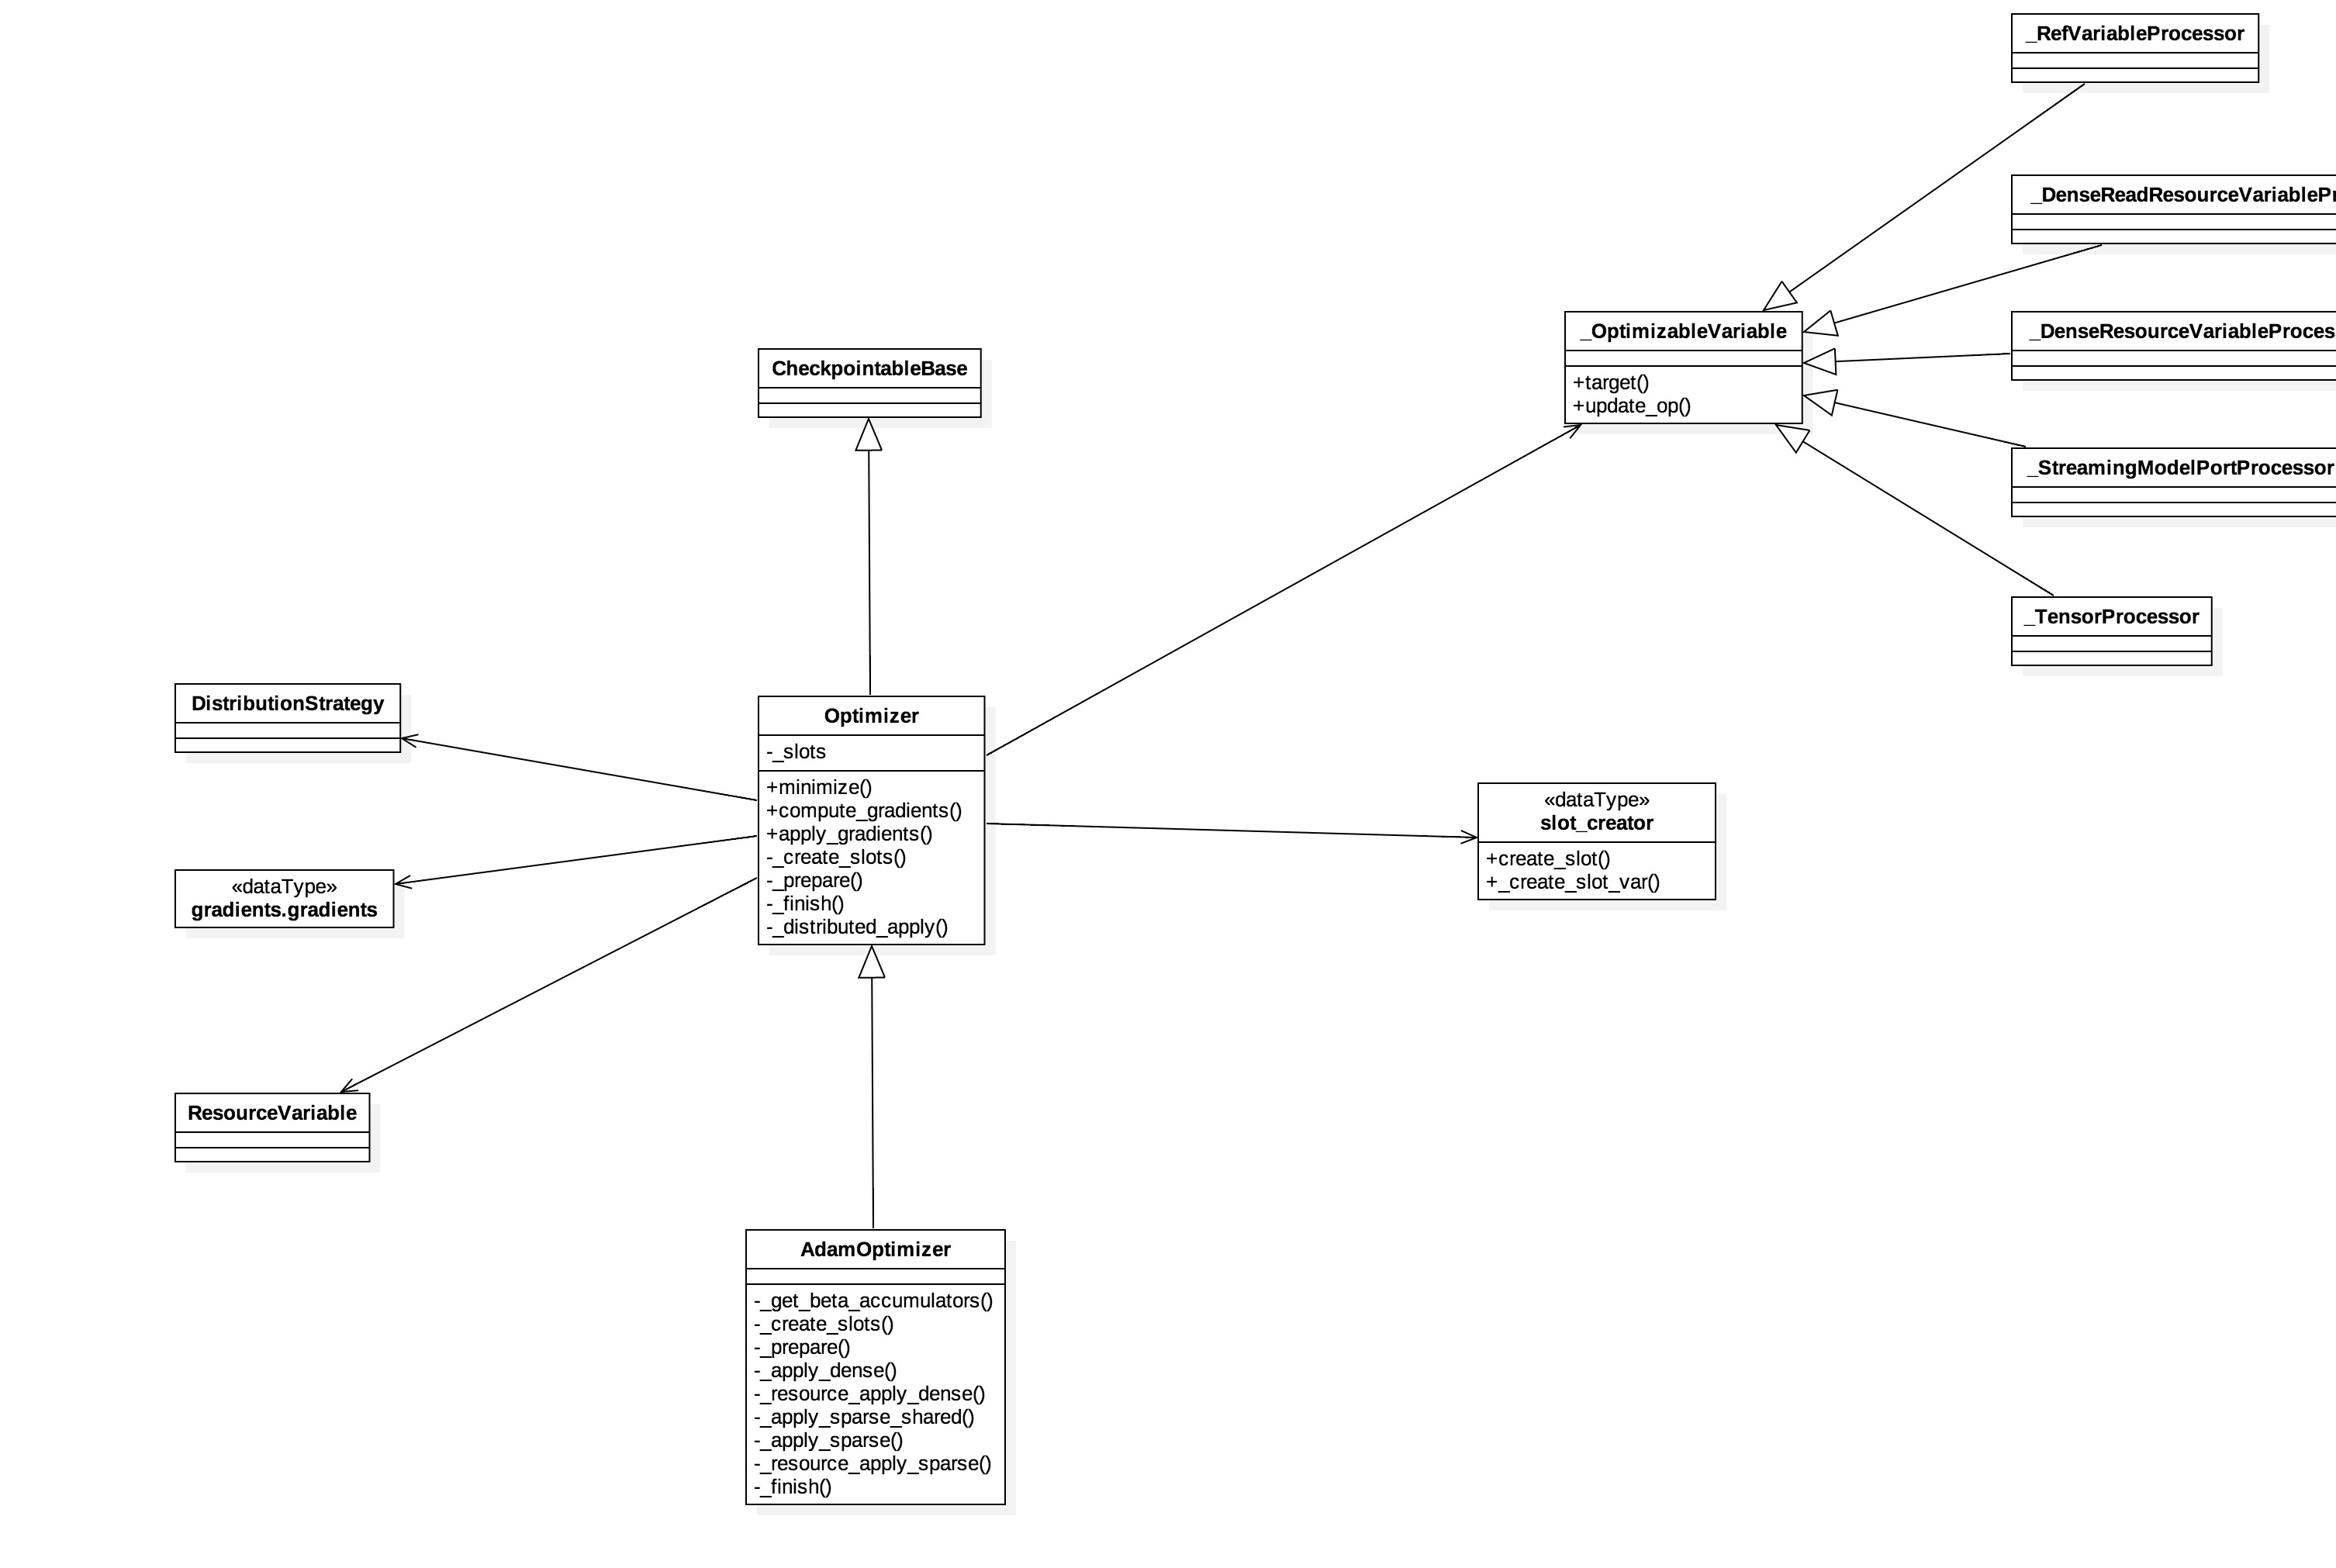

In [2]:
Image(filename='./res/optimizer.jpg')

有几个概念比较有意思，我尝试说下自己的理解：

+ slots: 它们也是变量，只是依附于每个变量的一些状态信息，比如历史梯度值一类。
  - non-slots: 优化器用于计算的全局信息。
+ compute_gradients参数：
  - gate_gradients: 这个把它理解成grads要不要相互同步，可能更好想。
  - colocate_gradients_with_ops：梯度和对应算子，放在同样设备上(tf.devices)。
+ `_apply_*`和`_resource_apply_*`这些方法会被_OptimizableVariable自动调用，很多时候重载这些方法就可以，复用apply_gradients逻辑。

### 小例子

我们以Adam优化器为例，用TensorBoard来简单讲讲。下面构建了简单的一个网络，输出graph到本地。

In [3]:
import tensorflow as tf
tf.__version__

/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.8.0-dev20180331'

In [4]:
# with tf.Graph().as_default():
summaries_dir = "./opt"
a = tf.placeholder(dtype=tf.float32, shape=(10, 2), name='a')
b = tf.get_variable('b', shape=(2, 1), dtype=tf.float32)
loss = tf.cumsum(tf.matmul(a, b), name='loss')

opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss)

with tf.Session() as sess:
    writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)

这个网络很简单，就是a乘以b，累加求和作为损失，再配上优化器寻优。用`tensorboard --logdir=opt`来打开，如下图：

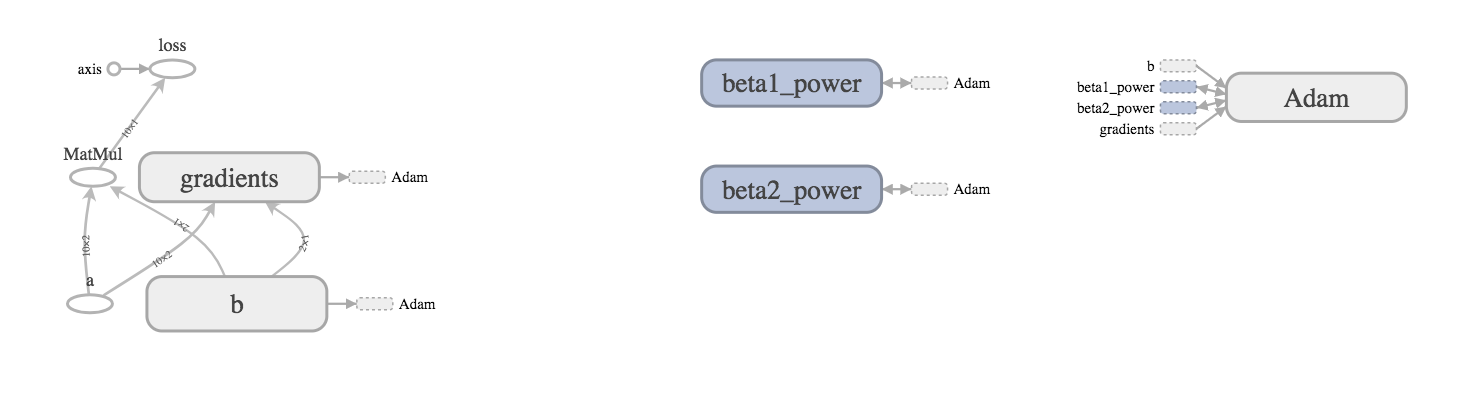

In [5]:
Image('./res/tensorboard/all.png')

Adam优化器的计算逻辑见官方注释：

    Initialization:

    ```
    m_0 <- 0 (Initialize initial 1st moment vector)
    v_0 <- 0 (Initialize initial 2nd moment vector)
    t <- 0 (Initialize timestep)
    ```

    The update rule for `variable` with gradient `g` uses an optimization
    described at the end of section2 of the paper:

    ```
    t <- t + 1
    lr_t <- learning_rate * sqrt(1 - beta2^t) / (1 - beta1^t)

    m_t <- beta1 * m_{t-1} + (1 - beta1) * g
    v_t <- beta2 * v_{t-1} + (1 - beta2) * g * g
    variable <- variable - lr_t * m_t / (sqrt(v_t) + epsilon)
    ```

首先，注意到Adam会为每个变量创建两个slots: m和v。我们展开变量b，就能看到相应的slots，它们的名字在同样空间下，分别是Adam和Adam_1，如下图：

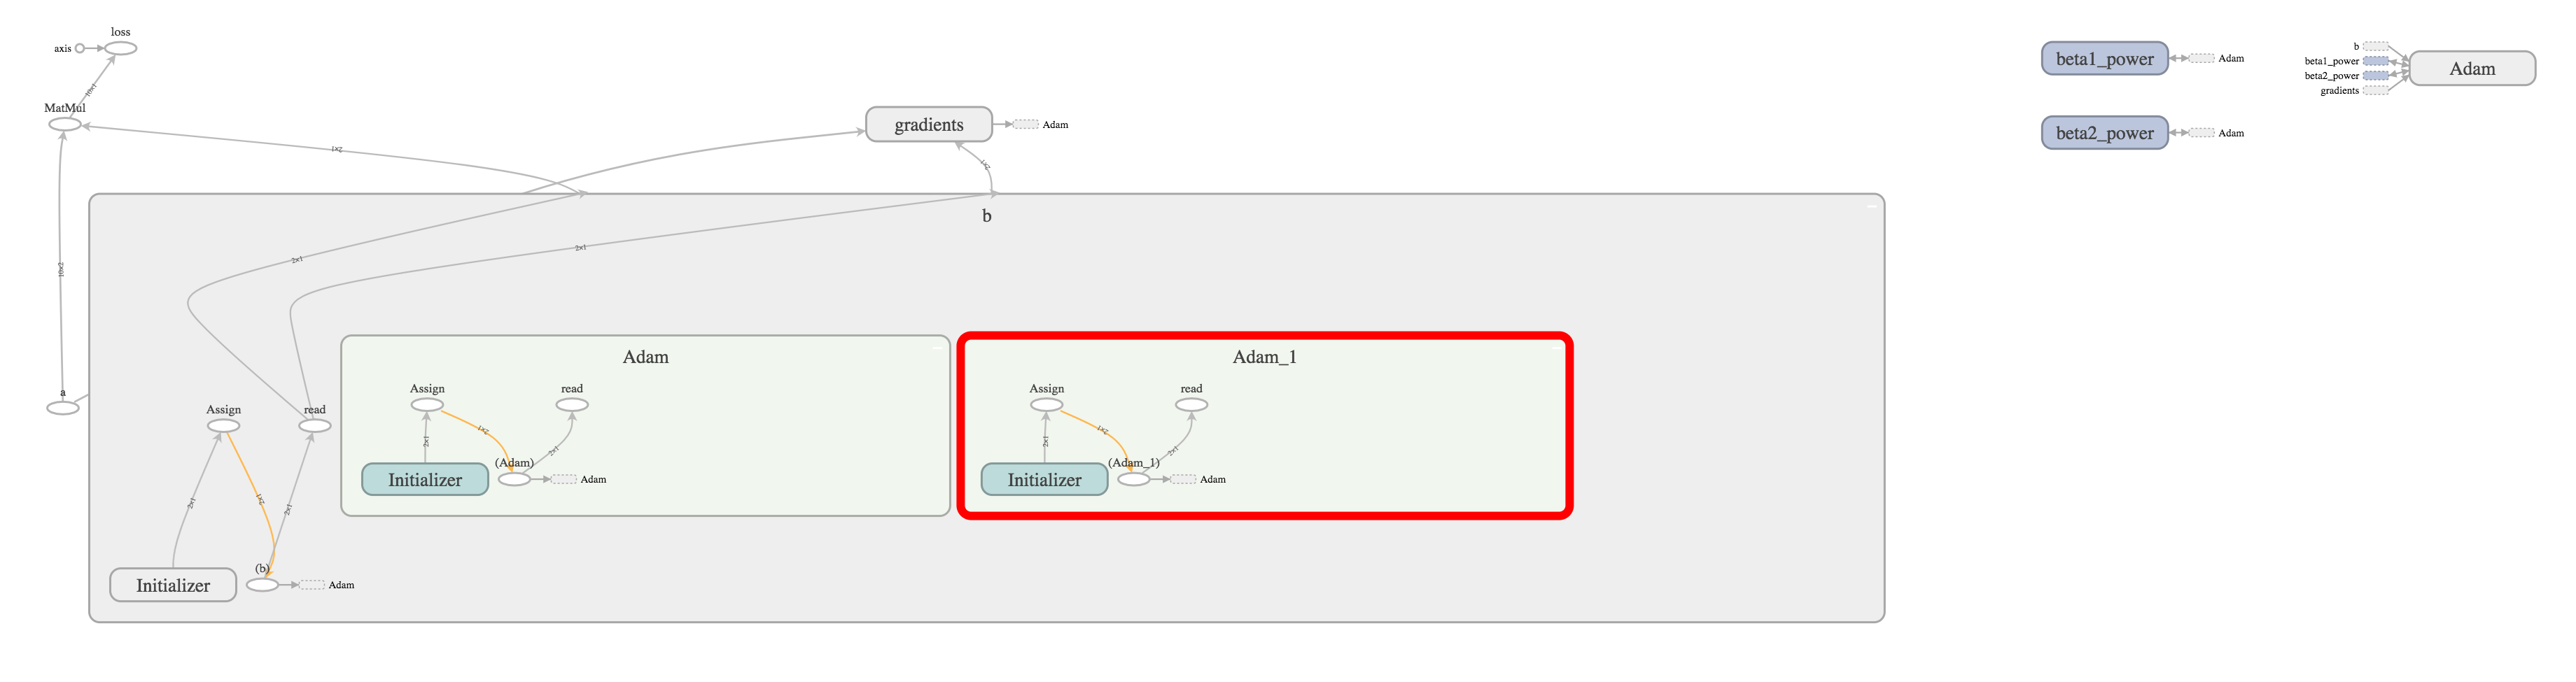

In [6]:
Image('./res/tensorboard/var_b.png')

然后，我们来看gradients中是如何算梯度的：

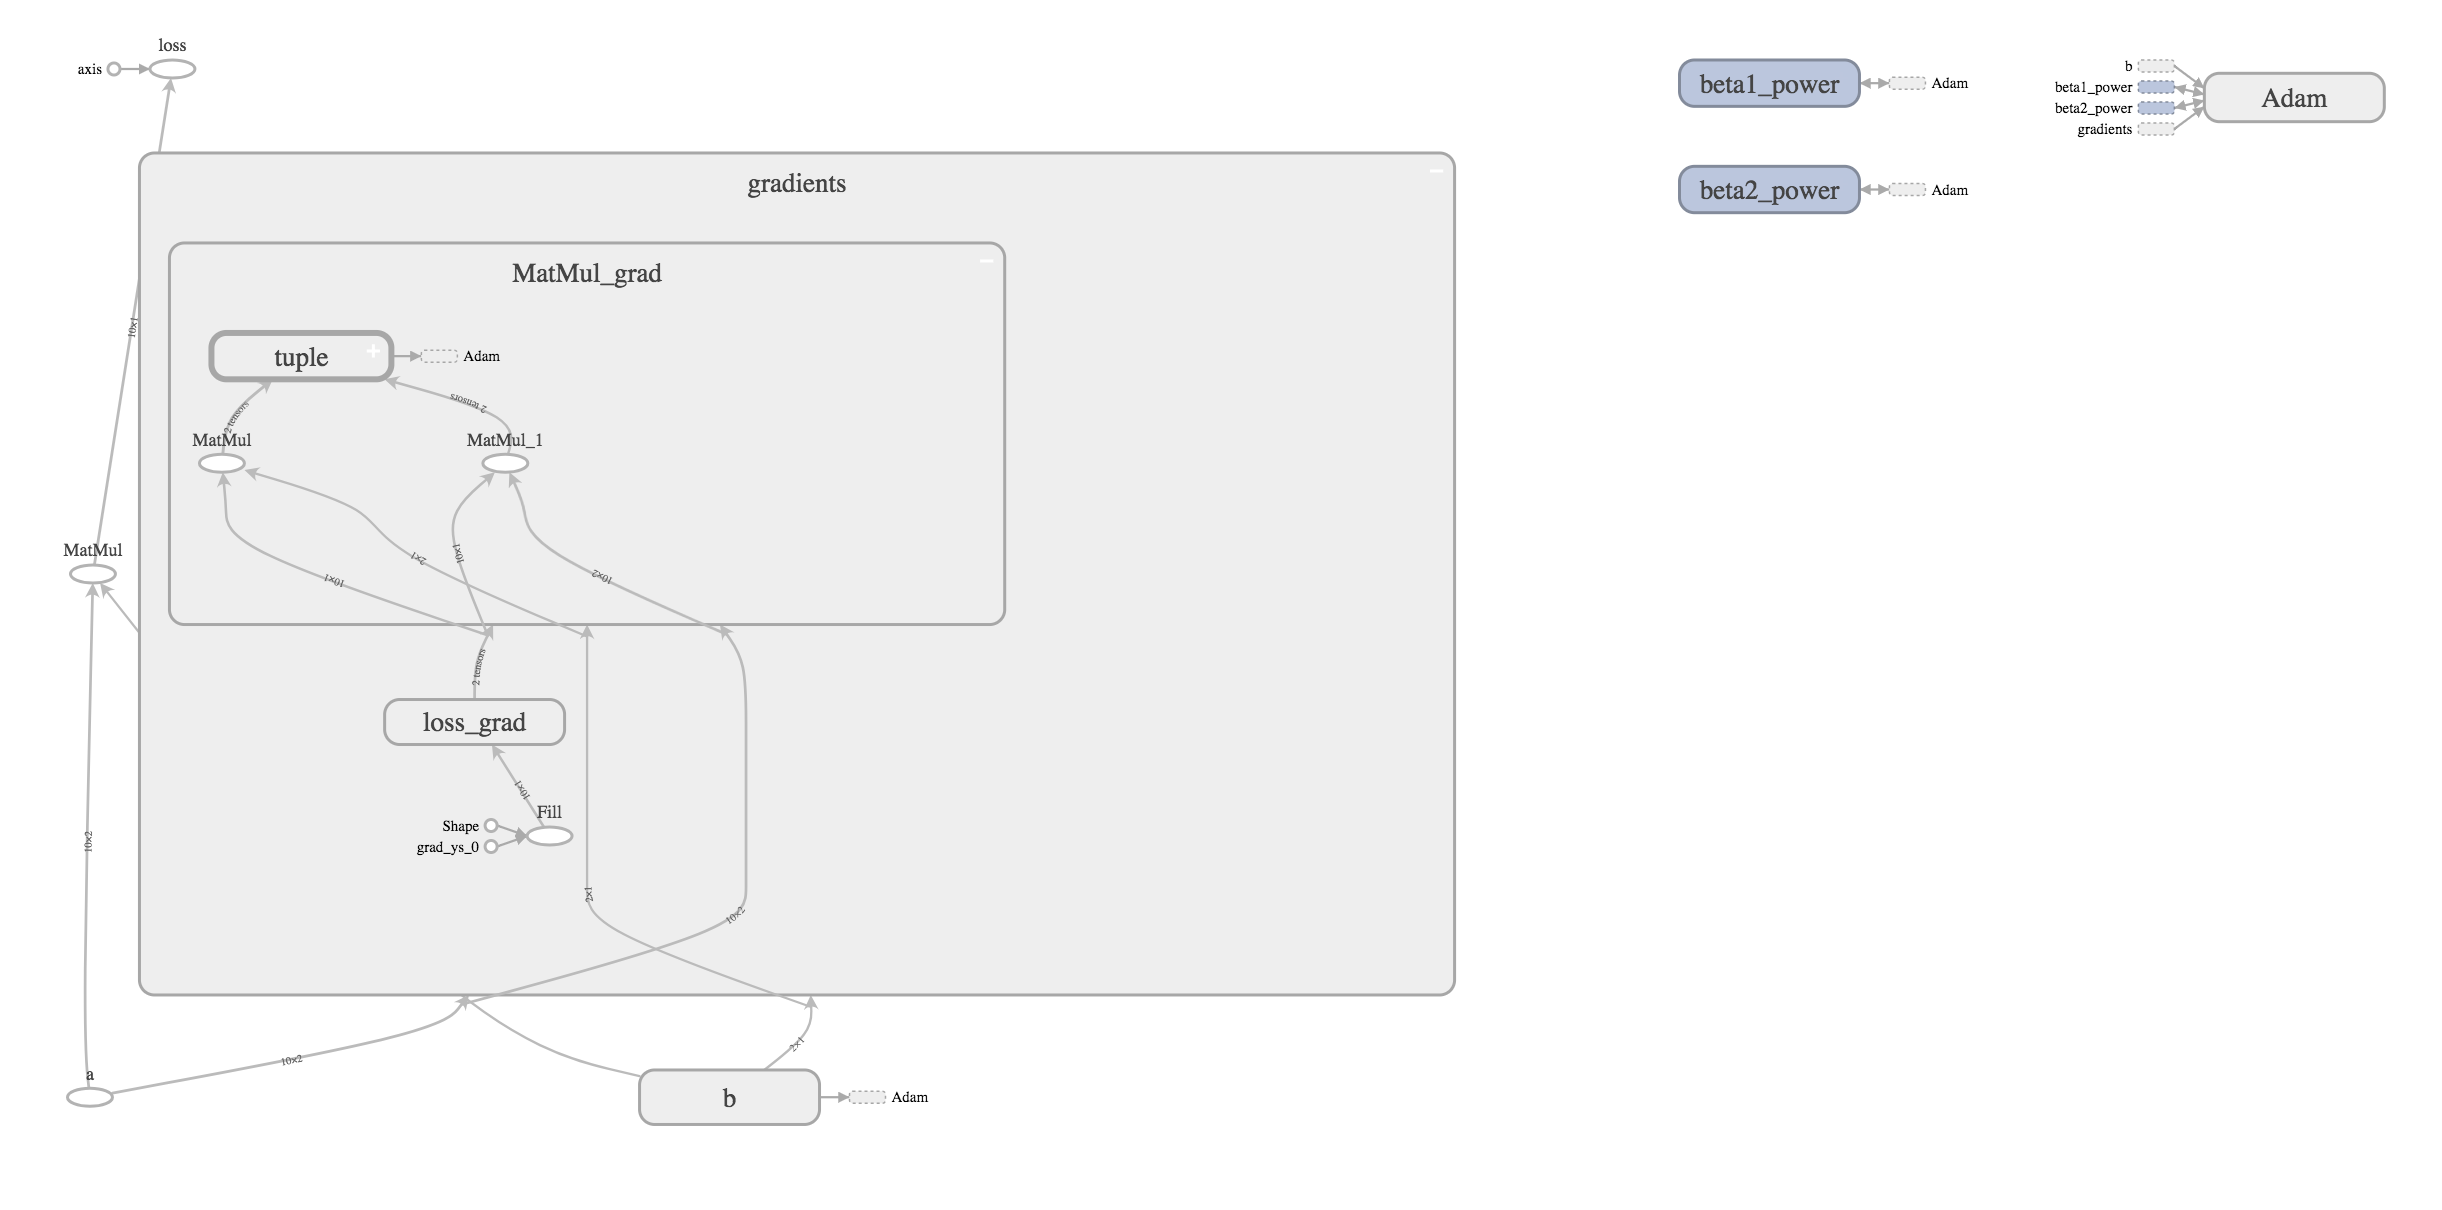

In [7]:
Image('./res/tensorboard/gradient.png')

从loss_grad来反算出MatMul_grad，从后往前反向求导。因为对于数乘$y = a * b$来说，梯度$da = b * dy$和$db = a * dy$，所以在梯度中有两个算子MatMul和MatMul_1，来计算相应的梯度。注意这两个梯度用tuple算子聚合在一起，这就是默认的GATE_OP行为：对于一个算子，它涉及的梯度要都解算完成。

最后再看Adam这块，它里面是update_b块，这是更新变量b的逻辑，然后再分别更新beta1_power和beta2_power变量。最后的(Adam)就是我们代码中的`train_op`。

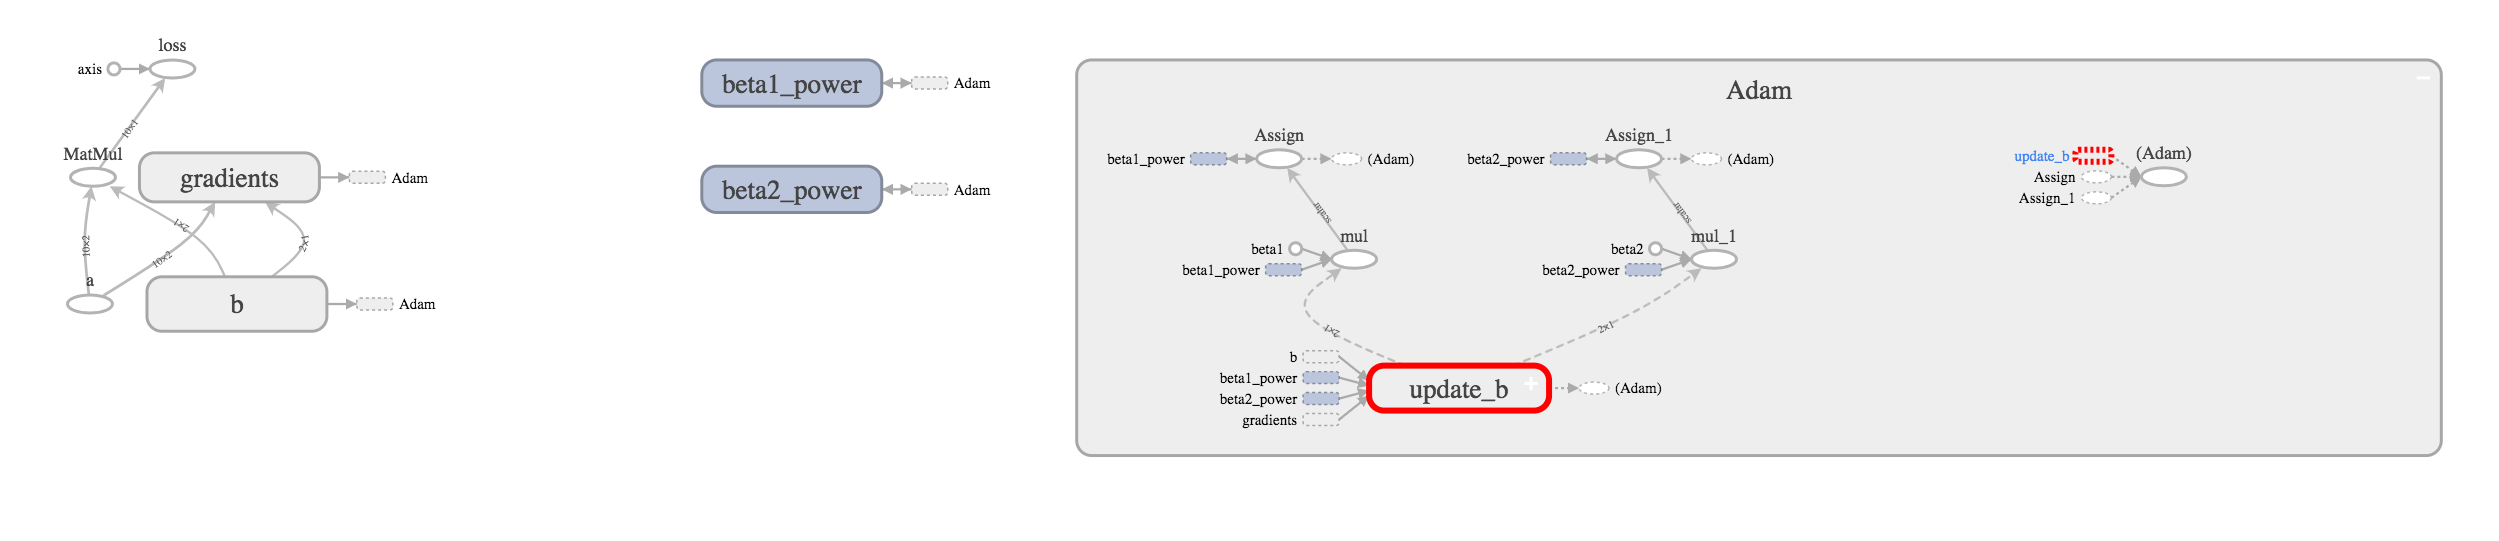

In [8]:
Image('./res/tensorboard/update.png')

所以当运行`sess.run(train_op)`时，整个网络就会从后往前，依次往前查找子图。再从前往后依次执行，完成一轮迭代。